## Load Data

In [414]:
import pandas as pd
import numpy as np
from scipy import optimize
from timeit import default_timer as timer
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [4]:
data_dir = '../Data/ml-latest-small'
ratings = pd.read_csv(f'{data_dir}/ratings.csv')
movies = pd.read_csv(f'{data_dir}/movies.csv')
tags = pd.read_csv(f'{data_dir}/tags.csv')
links = pd.read_csv(f'{data_dir}/links.csv')

In [123]:
ratings_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0).values

In [124]:
count = ratings.groupby('movieId').count()['userId'].rename('num_rating').reset_index()
count = pd.DataFrame(count)
movie_id = count[count['num_rating'] >= 20]['movieId']
ratings_subset = ratings[ratings['movieId'].isin(movie_id)]
ratings_subset_matrix = ratings_subset.pivot(index='userId', columns='movieId', values='rating').fillna(0).values

## Train-Validation-Test Split

In [218]:
# labeled indices of the original matrix
label_idx = np.asarray(np.where(ratings_subset_matrix > 0)).T
num_label = len(label_idx)
row, col = ratings_subset_matrix.shape
# training and validation set
train_val_len = int(num_label * 0.8)
train_val_split = np.random.choice(num_label, train_val_len, replace=False)
train_val_idx = label_idx[train_val_split]
train_val_matrix = np.zeros([row, col])
for i in range(len(train_val_idx)):
    r, c = train_val_idx[i]
    train_val_matrix[r, c] = ratings_subset_matrix[r, c]
# training set
num_train_val = len(train_val_idx)
train_len = int(num_train_val * 0.8)
train_split = np.random.choice(num_train_val, train_len, replace=False)
train_idx = train_val_idx[train_split]
train_matrix = np.zeros([row, col])
for i in range(len(train_idx)):
    r, c = train_idx[i]
    train_matrix[r, c] = ratings_subset_matrix[r, c]
# validation set
val_split = np.setdiff1d([i for i in range(num_train_val)], train_split)
val_idx = train_val_idx[val_split]
val_matrix = np.zeros([row, col])
for i in range(len(val_idx)):
    r, c = val_idx[i]
    val_matrix[r, c] = ratings_subset_matrix[r, c]
# test set
test_split = np.setdiff1d([i for i in range(num_label)], train_val_split)
test_idx = label_idx[test_split]
test_matrix = np.zeros([row, col])
for i in range(len(test_idx)):
    r, c = test_idx[i]
    test_matrix[r, c] = ratings_subset_matrix[r, c]

## Matrix Completion Algorithm

In [88]:
def loss(output, matrix, U, V, label_idx, penalty, index, update_u=True):
    if update_u:
        label_pair = label_idx[label_idx[:, 0] == index]
        cost = penalty/2 * sum(np.square(output))
        for j in range(label_pair.shape[0]):
            row, col = label_pair[j]
            cost += 1/2 * ((matrix[row, col] - np.dot(output, V[col])) ** 2)
    else:
        label_pair = label_idx[label_idx[:, 1] == index]
        cost = penalty/2 * sum(np.square(output))
        for j in range(label_pair.shape[0]):
            row, col = label_pair[j]
            cost += 1/2 * ((matrix[row, col] - np.dot(U[row], output)) ** 2)
    return cost

In [293]:
def matrix_factorization(matrix, k=2, penalty=0.1, iteration=1):
    # record labeled indices of the original matrix
    label_idx = np.asarray(np.where(matrix > 0)).T
    
    # initialize V randomly and initialize U as zero matrix
    n, m = matrix.shape
    V = np.random.rand(m, k)
    U = np.zeros([n, k])
    
    for iters in range(iteration):
        converge = False
        prev_U = U.copy()
        prev_V = V.copy()
        
        start = timer()
        
        # update U first
        for i in range(n):
            output = optimize.fmin(loss, U[i], args=(matrix, U, V, label_idx, penalty, i, True), disp=False)
            U[i] = output
        sum_diff = (np.square(U - prev_U)).sum()
        if sum_diff <= 1:
            converge = True
    
        # then update V
        for i in range(m):
            output = optimize.fmin(loss, V[i], args=(matrix, U, V, label_idx, penalty, i, False), disp=False)
            V[i] = output
        sum_diff = (np.square(V - prev_V)).sum()
        if sum_diff >= 1:
            converge = False
        
        print('Iteration', iters, 'total time:', round(timer() - start, 2), 'seconds')
        
        if converge == True:
            print('Converges at iteration', iters)
            break
    
    return U, V

## Training and Validation

In [294]:
def matrix_MAE(pred_matrix, target_matrix):
    label_idx = np.asarray(np.where(target_matrix > 0)).T
    num_label = len(label_idx)
    total_error = 0
    for i in range(num_label):
        row, col = label_idx[i]
        total_error += np.abs(pred_matrix[row, col] - target_matrix[row, col])
    return total_error / num_label

In [295]:
def validation(train_matrix, val_matrix, k, iteration, lambdas):
    train_error_list = []
    val_error_list = []
    best_val_error = 10000
    best_lambda = 0
    for penalty in lambdas:
        print('------ New Validation ------')
        U, V = matrix_factorization(train_matrix, k, penalty, iteration)
        pred_matrix = np.matmul(U, V.T)
        train_error = matrix_MAE(pred_matrix, train_matrix)
        train_error_list.append(train_error)
        val_error = matrix_MAE(pred_matrix, val_matrix)
        val_error_list.append(val_error)
        if val_error < best_val_error:
            best_val_error = val_error
            best_lambda = penalty
        print('Lambda is', penalty, 'Validation MAE :', round(val_error, 4))
    return best_lambda, train_error_list, val_error_list

In [296]:
lambdas = [0.01, 0.05, 0.1, 0.5, 1]
best_lambda, train_error_list, val_error_list = validation(train_matrix, val_matrix, 5, 10, lambdas)

------ New Validation ------
Iteration 0 total time: 310.37 seconds
Iteration 1 total time: 131.37 seconds
Iteration 2 total time: 119.91 seconds
Iteration 3 total time: 113.48 seconds
Iteration 4 total time: 107.98 seconds
Iteration 5 total time: 105.38 seconds
Iteration 6 total time: 102.65 seconds
Iteration 7 total time: 100.51 seconds
Iteration 8 total time: 98.83 seconds
Iteration 9 total time: 98.19 seconds
Lambda is 0.01 Validation MAE : 0.7953
------ New Validation ------
Iteration 0 total time: 314.16 seconds
Iteration 1 total time: 135.17 seconds
Iteration 2 total time: 120.41 seconds
Iteration 3 total time: 114.67 seconds
Iteration 4 total time: 110.06 seconds
Iteration 5 total time: 107.5 seconds
Iteration 6 total time: 106.3 seconds
Iteration 7 total time: 104.48 seconds
Iteration 8 total time: 101.75 seconds
Iteration 9 total time: 100.41 seconds
Lambda is 0.05 Validation MAE : 0.7813
------ New Validation ------
Iteration 0 total time: 313.11 seconds
Iteration 1 total ti

In [298]:
lambdas2 = [2, 3, 4, 5]
best_lambda2, train_error_list2, val_error_list2 = validation(train_matrix, val_matrix, 5, 10, lambdas2)

------ New Validation ------
Iteration 0 total time: 320.42 seconds
Iteration 1 total time: 120.38 seconds
Iteration 2 total time: 113.54 seconds
Iteration 3 total time: 109.17 seconds
Iteration 4 total time: 107.38 seconds
Iteration 5 total time: 103.78 seconds
Iteration 6 total time: 103.46 seconds
Iteration 7 total time: 100.88 seconds
Iteration 8 total time: 100.52 seconds
Iteration 9 total time: 98.4 seconds
Lambda is 2 Validation MAE : 0.6775
------ New Validation ------
Iteration 0 total time: 329.07 seconds
Iteration 1 total time: 120.02 seconds
Iteration 2 total time: 110.69 seconds
Iteration 3 total time: 106.85 seconds
Iteration 4 total time: 105.57 seconds
Iteration 5 total time: 104.97 seconds
Iteration 6 total time: 103.97 seconds
Iteration 7 total time: 100.71 seconds
Iteration 8 total time: 98.39 seconds
Iteration 9 total time: 96.1 seconds
Lambda is 3 Validation MAE : 0.6748
------ New Validation ------
Iteration 0 total time: 320.2 seconds
Iteration 1 total time: 114.

In [435]:
lambdas3 = [6, 8, 10, 12]
best_lambda3, train_error_list3, val_error_list3 = validation(train_matrix, val_matrix, 5, 10, lambdas3)

------ New Validation ------
Iteration 0 total time: 318.7 seconds
Iteration 1 total time: 110.75 seconds
Iteration 2 total time: 101.82 seconds
Iteration 3 total time: 100.18 seconds
Iteration 4 total time: 98.87 seconds
Iteration 5 total time: 96.8 seconds
Iteration 6 total time: 94.83 seconds
Iteration 7 total time: 93.89 seconds
Iteration 8 total time: 91.81 seconds
Iteration 9 total time: 90.54 seconds
Lambda is 6 Validation MAE : 0.6704
------ New Validation ------
Iteration 0 total time: 313.65 seconds
Iteration 1 total time: 107.14 seconds
Iteration 2 total time: 96.74 seconds
Iteration 3 total time: 94.88 seconds
Iteration 4 total time: 93.16 seconds
Iteration 5 total time: 91.27 seconds
Iteration 6 total time: 90.62 seconds
Iteration 7 total time: 89.69 seconds
Iteration 8 total time: 87.78 seconds
Iteration 9 total time: 85.24 seconds
Lambda is 8 Validation MAE : 0.6822
------ New Validation ------
Iteration 0 total time: 310.5 seconds
Iteration 1 total time: 102.88 seconds


In [305]:
U, V = matrix_factorization(train_val_matrix, k=5, penalty=4, iteration=10)

Iteration 0 total time: 380.47 seconds
Iteration 1 total time: 144.36 seconds
Iteration 2 total time: 130.19 seconds
Iteration 3 total time: 125.72 seconds
Iteration 4 total time: 120.34 seconds
Iteration 5 total time: 120.97 seconds
Iteration 6 total time: 117.54 seconds
Iteration 7 total time: 114.45 seconds
Iteration 8 total time: 111.02 seconds
Iteration 9 total time: 111.56 seconds


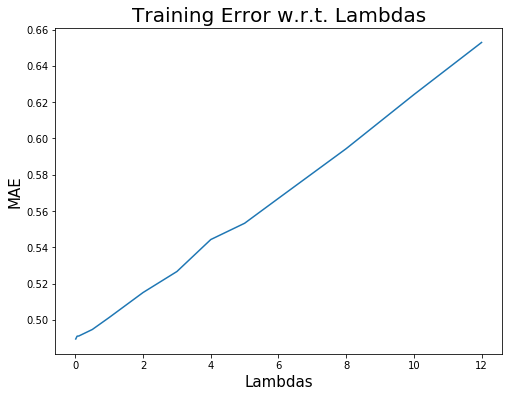

In [455]:
plt.figure(figsize=[8,6])
plt.plot(lambdas + lambdas2 + lambdas3, train_error_list + train_error_list2 + train_error_list3)
plt.title('Training Error w.r.t. Lambdas', fontsize=20)
plt.xlabel('Lambdas', fontsize=15)
plt.ylabel('MAE', fontsize=15);

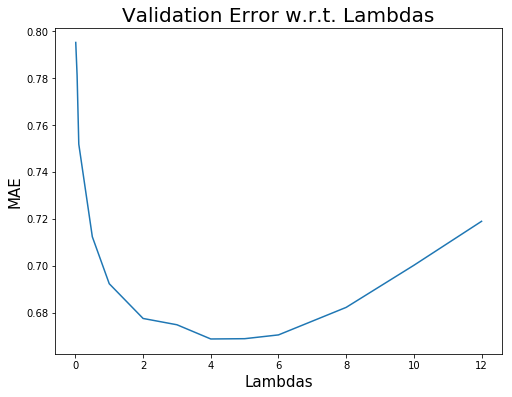

In [456]:
plt.figure(figsize=[8,6])
plt.plot(lambdas + lambdas2 + lambdas3, val_error_list + val_error_list2 + val_error_list3)
plt.title('Validation Error w.r.t. Lambdas', fontsize=20)
plt.xlabel('Lambdas', fontsize=15)
plt.ylabel('MAE', fontsize=15);

## Vanilla Model Performance

In [369]:
pred_matrix = np.matmul(U, V.T)
train_mae = matrix_MAE(pred_matrix, train_val_matrix)
test_mae = matrix_MAE(pred_matrix, test_matrix)
print('MAE of Training:', round(train_mae, 4))
print('MAE of Testing:', round(test_mae, 4))

MAE of Training: 0.5448
MAE of Testing: 0.6517


## Featurization for Ensemble Model

In [364]:
def featurization(ratings, movies, subset=True):
    ratings_copy = ratings.copy()
    movies_copy = movies.copy()
    
    def release_year(title):
        split1 = re.findall('\([0-9]{4}\)', title)
        if len(split1) > 0:
            split2 = int(re.findall('[0-9]{4}', split1[0])[0])
            return split2
        else:
            return 9999
    
    movies_copy['year'] = [release_year(title) for title in movies_copy['title']]
    movies_copy['before_1980'] = [1 if year < 1980 else 0 for year in movies_copy['year']]
    movies_copy['1980_2000'] = [1 if year >= 1980 and year < 2000 else 0 for year in movies_copy['year']]
    movies_copy['2000_2010'] = [1 if year >= 2000 and year < 2010 else 0 for year in movies_copy['year']]
    movies_copy['after_2010'] = [1 if year >= 2010 and year < 9999 else 0 for year in movies_copy['year']]
    movies_copy['genres'] = [genres.split('|') for genres in movies_copy['genres']]
    genres = pd.get_dummies(movies_copy['genres'].apply(pd.Series).stack()).sum(level=0)
    movies_copy = pd.concat([movies_copy, genres], axis=1)
    
    feature_df = pd.merge(ratings_copy, movies_copy, how='left', on='movieId')
    feature_df = feature_df.drop(columns=['title', 'genres', 'year', 'timestamp'])
    
    if subset:
        count = feature_df.groupby('movieId').count()['userId'].rename('num_rating').reset_index()
        count = pd.DataFrame(count)
        movie_id = count[count['num_rating'] >= 20]['movieId']
        feature_df = feature_df[feature_df['movieId'].isin(movie_id)]
    
    movieid_dict = {}
    sorted_id = sorted(feature_df['movieId'].unique())
    for i in range(len(sorted_id)):
        movieid_dict[sorted_id[i]] = i
    feature_df['movieId'] = [movieid_dict[Id] for Id in feature_df['movieId']]
    
    feature_df['userId'] = [Id - 1 for Id in feature_df['userId']]
    
    return feature_df

featurized_matrix = featurization(ratings, movies)

In [389]:
pred_list = []
for i in range(len(label_idx)):
    row, col = label_idx[i]
    pred_list.append(pred_matrix[row, col])
featurized_matrix['matrix_completion_pred'] = pred_list

,userId,movieId,rating,before_1980,1980_2000,2000_2010,after_2010,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,4.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,2,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,4,4.0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,24,5.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,26,5.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


## Training an Ensemble Model

In [410]:
X = featurized_matrix.drop(columns=['userId', 'movieId', 'rating'])
y = featurized_matrix['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [462]:
rf = RandomForestRegressor(max_depth=10, n_estimators=10, min_samples_split=2, min_samples_leaf=4, criterion='mae', random_state=0)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [473]:
pred = rf.predict(X_test)
metrics.mean_absolute_error(pred, y_test)

0.5472312223858615

In [415]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [421]:
pred = regr.predict(X_test)
metrics.mean_absolute_error(pred, y_test)

0.563092207501974

In [465]:
rf2 = RandomForestRegressor(max_depth=10, n_estimators=20, min_samples_split=2, min_samples_leaf=4, criterion='mae', random_state=0)
rf2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [467]:
pred = rf2.predict(X_test)
metrics.mean_absolute_error(pred, y_test)

0.546750736377025

In [476]:
np.mean(ratings_subset['rating'])

3.6230595893840762